# Fit an SI pair model without accounting for gender to real data

 Produces Figure 1 in the paper


## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm
import scipy.stats as stats
import numdifftools as nd # This may need to be installed on your sustem using conda, pip etc.
from numpy import linalg as LA
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from scipy.interpolate import RectBivariateSpline
import math

## Data, Parameters and Initial Conditions

In [2]:
# The data is just a few integers, so enter by hand

observed_data = np.array([
    [1742, 43, 17],  # First observation: [ss_pairs, si_pairs, ii_pairs]
    [1721, 58, 23]   # Second observation: [ss_pairs, si_pairs, ii_pairs]
])
time_points = [0, 2]  # Time points corresponding to the observations (years)

In [3]:
# These are starting values for the optimiser from a heuristic formula

lambda_ = (observed_data[1,1] - observed_data[0,1])/(4 * observed_data[0,0])
print(lambda_)
tau_ = tau = (observed_data[1,2] - observed_data[0,2])/(2 * observed_data[0,1])
print(tau_)

initial_guess = np.array([lambda_, tau_]) # Array of initial guesses for parameters

0.002152698048220436
0.06976744186046512


In [4]:
# Initial conditions for the model
total_pairs = np.sum(observed_data[0])  # Total pairs from the first observation

# State vector for the ODE solver
initial_state = observed_data[0]  # Use the first observation as initial conditions

## Differential Equations

In [5]:
# Define the differential equations for the epidemic model

def epidemic_model(t, y, lam, tau):
    P_ss, P_si, P_ii = y
    
    dP_ss = - 2 * lam * P_ss
    dP_si = 2 * lam * P_ss - lam * P_si - tau * P_si
    dP_ii = lam* P_si + tau * P_si
    
    return np.array([dP_ss, dP_si, dP_ii])

## Solving the System of Equations

In [6]:
# Total time and number of time steps for 2 years
T = 2.0
t_eval = np.linspace(0, T, 1000)  # 2 years with 1000 time points

In [7]:
# Solve the differential equations using solve_ivp
odefun = lambda t, x: epidemic_model(t,x,lambda_,tau_) 
sol = solve_ivp(odefun, (0, T), initial_state, t_eval=t_eval)

In [8]:
# Extract the solution
pairs_ss = sol.y[0]
pairs_si = sol.y[1]
pairs_ii = sol.y[2]

In [9]:
#Converting to Compartment Variables
prob_to_quant =np.array([[2,0], [1,1], [0,2]]).T
y_si = prob_to_quant.dot(sol.y)

## Plotting Results

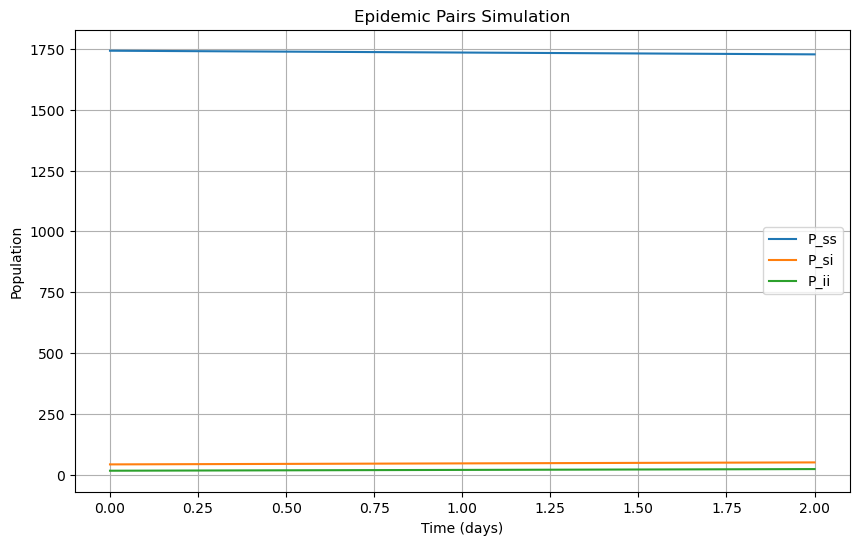

In [10]:
# Plot pairs over time
plt.figure(figsize=(10, 6))
plt.plot(t_eval, pairs_ss, label='P_ss')
plt.plot(t_eval, pairs_si, label='P_si')
plt.plot(t_eval, pairs_ii, label='P_ii')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.legend()
plt.title('Epidemic Pairs Simulation')
plt.grid(True)

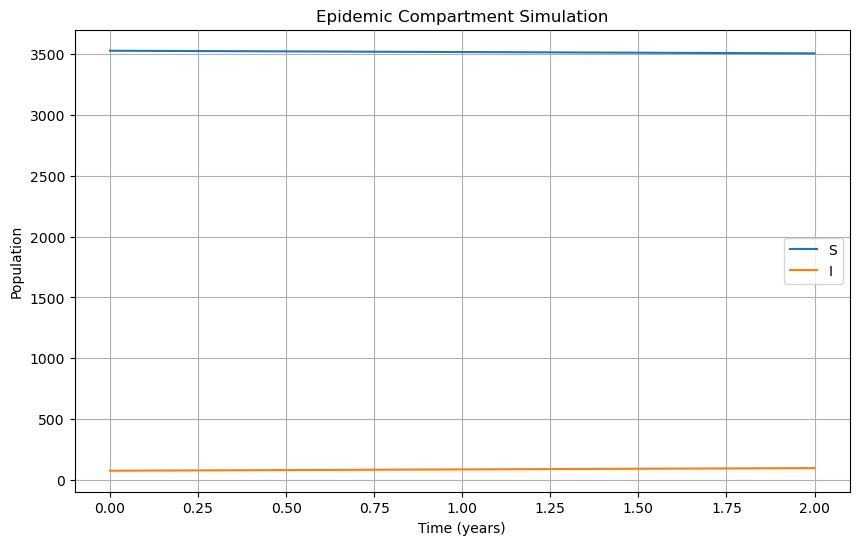

In [11]:
# Plot compartments over time
plt.figure(figsize=(10, 6))
plt.plot(t_eval, y_si[0,:], label='S')
plt.plot(t_eval, y_si[1,:], label='I')
plt.xlabel('Time (years)')
plt.ylabel('Population')
plt.legend()
plt.title('Epidemic Compartment Simulation')
plt.grid(True)

## Log-Likelihood Function

In [12]:
def myll(lam, tau):
    odefun = lambda t, x: epidemic_model(t,x,lam,tau) 
    sol = solve_ivp(odefun, (time_points[0], time_points[-1]), initial_state, t_eval=time_points)
    model_predictions = sol.y.T
    prob_predictions = model_predictions / total_pairs
    prob_predictions = np.clip(prob_predictions, 1e-10, 1 - 1e-10)
    ll = 0
    for i, obs in enumerate(observed_data):
        ll += stats.multinomial.logpmf(obs, total_pairs, prob_predictions[i])
    
    return ll

In [13]:
#Create a log-likelihood surface
lamrange = np.arange(0.0,0.0065,0.00006)
taurange = np.arange(0.0,0.1515,0.0015)
llmat = np.zeros((len(lamrange),len(taurange)))
for i, lam in enumerate(tqdm(lamrange)):
    for j, tau in enumerate(taurange):
        llmat[i,j] = myll(lam,tau)

100%|███████████████████████████████████████| 109/109 [00:01<00:00, 68.02it/s]


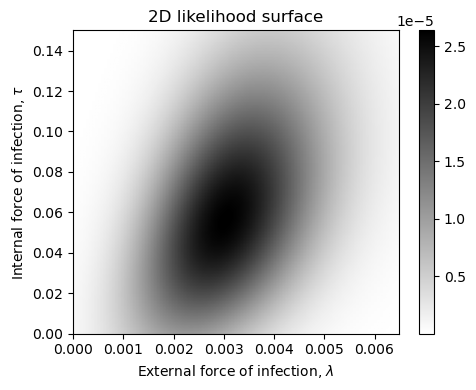

In [14]:
# Plot a 2D likelihood surface (heatmap) for lambda and tau

plt.figure(figsize=(5,4))
plt.imshow(
    np.exp(llmat).T,
    cmap = plt.colormaps['binary'],
    aspect = 'auto',
    origin = 'lower',
    extent = [lamrange[0],lamrange[-1],taurange[0],taurange[-1]],
)

plt.colorbar()
plt.xlabel(r'External force of infection, $\lambda$')
plt.ylabel(r'Internal force of infection, $\tau$')
plt.title('2D likelihood surface')
plt.tight_layout()

Grid MLE: 0.0030600000000000002 0.057
Refined MLE: 0.003032090331871559 0.05617547166672027


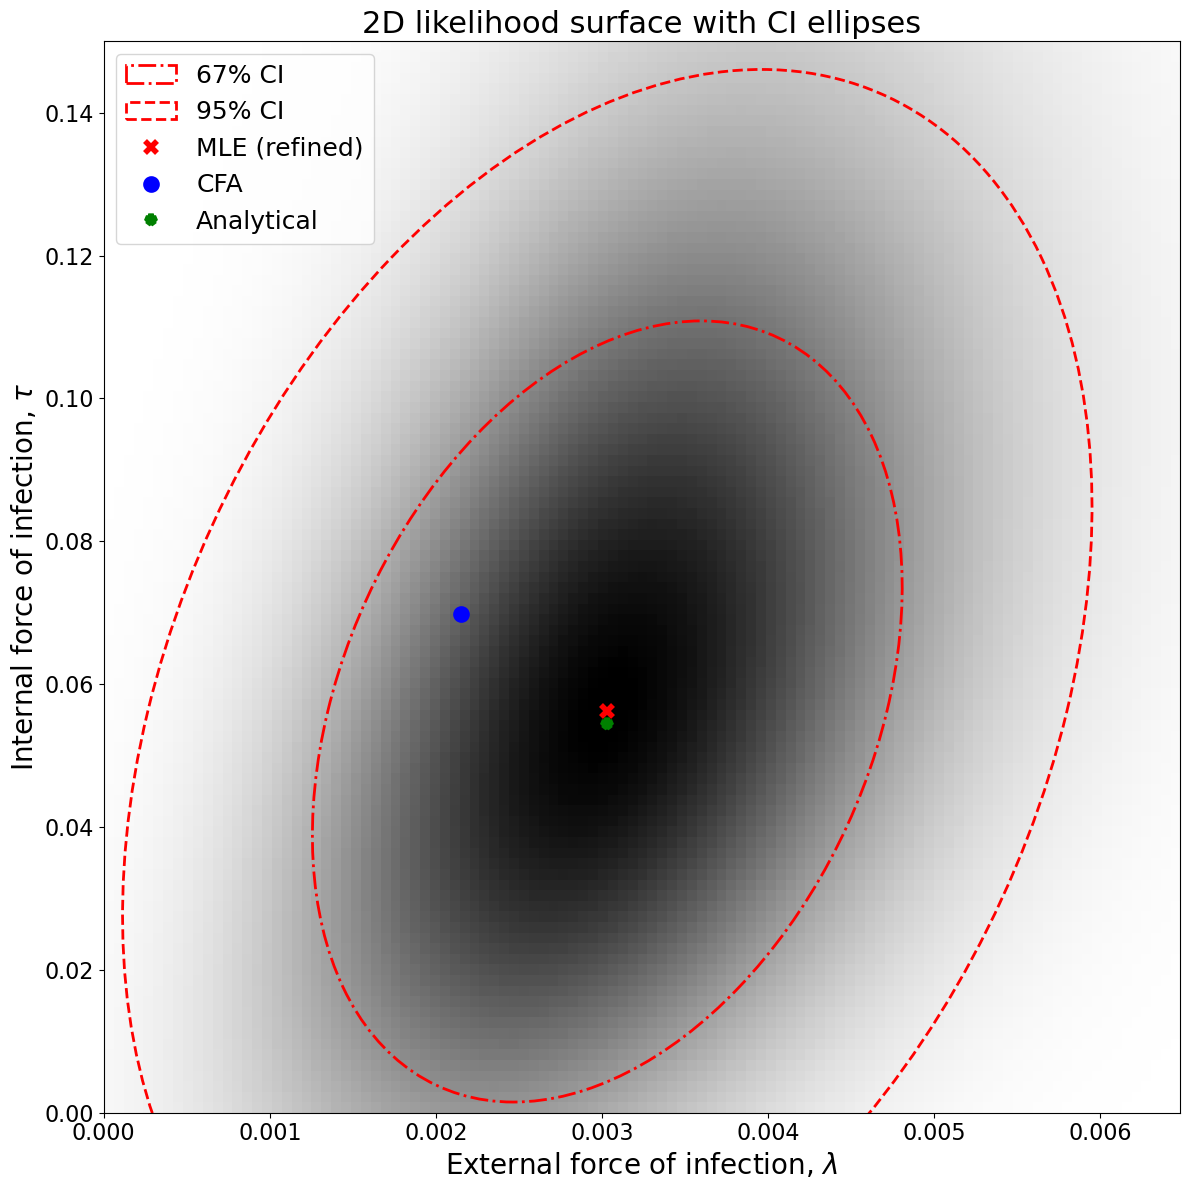

In [15]:
# Find grid-based MLE
max_idx = np.unravel_index(np.argmax(llmat), llmat.shape)
lam_mle = lamrange[max_idx[0]]
tau_mle = taurange[max_idx[1]]

# Build smooth likelihood interpolator
ll_interp = RectBivariateSpline(lamrange, taurange, llmat)

def neg_loglik(params):
    lam, tau = params
    return -ll_interp(lam, tau)[0][0]

# Refine MLE with continuous optimization
res = minimize(
    neg_loglik,
    x0=[lam_mle, tau_mle],
    method='Nelder-Mead',
    options={'xatol':1e-12, 'fatol':1e-12}
)

lam_mle_refined, tau_mle_refined = res.x
print("Grid MLE:", lam_mle, tau_mle)
print("Refined MLE:", lam_mle_refined, tau_mle_refined)

# ------------------------------------------------
# Estimate covariance around refined MLE using pseudo-density
ll_centered = llmat - np.max(llmat)
prob_surface = np.exp(ll_centered)
weights = prob_surface / np.sum(prob_surface)

LAMBDA, TAU = np.meshgrid(lamrange, taurange, indexing='ij')
coords = np.stack([LAMBDA.ravel(), TAU.ravel()], axis=1)
mean = np.array([lam_mle_refined, tau_mle_refined])
diffs = coords - mean
cov = np.cov(diffs.T, aweights=weights.ravel())

# Confidence levels and ellipse parameters
confidence_levels = [0.67, 0.95]
colors = ['red', 'red']
styles = ['dashdot', 'dashed']

eigvals, eigvecs = np.linalg.eigh(cov)
order = eigvals.argsort()[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]
angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

# ------------------------------------------------
# Analytical results

lambda_analytical = (1 / 4) * math.log(observed_data[0, 0] / observed_data[1, 0])
tau_analytical = (16.95 + 1) * lambda_analytical
# ------------------------------------------------

# Plot heatmap
plt.figure(figsize=(12, 12))
plt.imshow(
    np.exp(llmat).T,
    cmap=plt.colormaps['binary'],
    aspect='auto',
    origin='lower',
    extent=[lamrange[0], lamrange[-1], taurange[0], taurange[-1]],
)
plt.xlim(lamrange[0], lamrange[-1])
plt.ylim(taurange[0], taurange[-1])

# Add ellipses
for conf, color, style in zip(confidence_levels, colors, styles):
    delta_chi2 = chi2.ppf(conf, df=2)
    width, height = 2 * np.sqrt(eigvals * delta_chi2)
    ellipse = Ellipse(
        (lam_mle_refined, tau_mle_refined), width, height, angle=angle,
        edgecolor=color, facecolor='none', lw=2, linestyle=style,
        label=f'{int(conf * 100)}% CI'
    )
    plt.gca().add_patch(ellipse)

# Add markers
plt.plot(lam_mle_refined, tau_mle_refined, 'rx', markersize=8, mew=4, label='MLE (refined)')
plt.plot(lambda_, tau_, 'bo', markersize=8, mew=4, label='CFA')
plt.plot(lambda_analytical, tau_analytical, 'g*', markersize=8, mew=4, label='Analytical')

# Ticks and labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'External force of infection, $\lambda$', fontsize=20)
plt.ylabel(r'Internal force of infection, $\tau$', fontsize=20)
plt.title('2D likelihood surface with CI ellipses', fontsize=22)
plt.legend(loc=2, prop={'size': 18})
plt.tight_layout()

plt.savefig('./Figure1.pdf')

## Formal Parameter Estimation and Hessian

In [16]:
#Negative log-likelihood function
neg_llh = lambda params: -myll(params[0], params[1])

In [17]:
def mycall(x):
    print('trying ' + str(x))

In [18]:
#Estimate parameters
result = minimize(neg_llh, initial_guess, method='Nelder-Mead', callback=mycall)
print(result)

#Store results of the minimisation
xhat = result.x
print('Estimated array = ' + str(xhat))

trying [0.00231415 0.0627907 ]
trying [0.00255633 0.05930233]
trying [0.00278505 0.04360465]
trying [0.00278505 0.04360465]
trying [0.00273124 0.0505814 ]
trying [0.00273124 0.0505814 ]
trying [0.00286578 0.05406977]
trying [0.00286578 0.05406977]
trying [0.00298014 0.05145349]
trying [0.00300032 0.05755814]
trying [0.00300032 0.05755814]
trying [0.00300032 0.05755814]
trying [0.00306213 0.0553234 ]
trying [0.00302502 0.05514626]
trying [0.00302195 0.05639648]
trying [0.00302195 0.05639648]
trying [0.00302195 0.05639648]
trying [0.00303682 0.05607222]
trying [0.00303682 0.05607222]
trying [0.00302623 0.05620448]
trying [0.00302623 0.05620448]
trying [0.00303468 0.05616822]
trying [0.00303465 0.05625516]
trying [0.00303465 0.05625516]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 10.542907324565022
             x: [ 3.035e-03  5.626e-02]
           nit: 24
          nfev: 45
 final_simplex: (array([[ 3.035e-03,  5.626e-02],


In [19]:
pn = len(xhat) # Number of parameters
delta = 1e-2
dx = delta*xhat
ej = np.zeros(pn)
ek = np.zeros(pn)
Hinv = np.zeros((pn,pn))
for j in tqdm(range(0,pn)):
    ej[j] = dx[j]
    for k in range(0,j):
        ek[k] = dx[k]
        Hinv[j,k] = neg_llh(xhat+ej+ek) - neg_llh(xhat+ej-ek) - neg_llh(xhat-ej+ek) + neg_llh(xhat-ej-ek)
        ek[k] = 0.
    Hinv[j,j] = - neg_llh(xhat+2*ej) + 16*neg_llh(xhat+ej) - 30*neg_llh(xhat) + 16*neg_llh(xhat-ej) -neg_llh(xhat-2*ej)
    ej[j] = 0.
Hinv += np.triu(Hinv.T,1)
Hinv /= (4.*np.outer(dx,dx) + np.diag(8.*dx**2))
covmat = LA.inv(0.5*(Hinv+Hinv.T))
stds = np.sqrt(np.diag(covmat))
print(stds)

100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 581.37it/s]

[0.0012779  0.04664341]


In [20]:
# Display estimates

print(
    'Estimate of Lambda = {:0.5f}[{:0.5f},{:0.5f}].'.format(
        xhat[0],
        xhat[0] - 1.96*np.sqrt(covmat[0,0]),
        xhat[0] + 1.96*np.sqrt(covmat[0,0])
    )
)
print(
    'Estimate of tau = {:0.4f}[{:0.4f},{:0.4f}].'.format(
        xhat[1],
        xhat[1] - 1.96*np.sqrt(covmat[1,1]),
        xhat[1] + 1.96*np.sqrt(covmat[1,1])
    )
)

Estimate of Lambda = 0.00303[0.00053,0.00554].
Estimate of tau = 0.0563[-0.0352,0.1477].
